# Imports / Config

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from collections import Counter
from datetime import datetime
from functools import reduce
from operator import itemgetter
import os
import pickle
import pprint
import sys

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from tqdm import tqdm_notebook

%matplotlib inline
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from content_corpus import ContentCorpus

pp = pprint.PrettyPrinter()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


# Load recent content corpus

In [3]:
%%time
recent_content_corpus = ContentCorpus(verbose=True)

CPU times: user 13 µs, sys: 0 ns, total: 13 µs
Wall time: 18.1 µs


In [4]:
%%time
recent_content_corpus.load_recent_content(df=pd.read_csv('../data/recent_content_corpus.csv', index_col=0),
                                          days_of_recent_content=2)
recent_content_corpus.df['meta_keywords'] = recent_content_corpus.df['meta_keywords'].apply(lambda x: x if type(x)== type('this') else '')
# recent_content_corpus.load_recent_content(days_of_recent_content=2)

CPU times: user 1.51 s, sys: 385 ms, total: 1.9 s
Wall time: 2.56 s


In [5]:
# recent_content_corpus.df.to_csv('recent_content_corpus.csv')

In [6]:
%%time
recent_content_corpus.vectorize_content()

CPU times: user 1min 58s, sys: 16 s, total: 2min 14s
Wall time: 1min 21s


In [7]:
%%time
recent_content_corpus.categorize_content()


 svm classifier performance
 accuracy:   0.847
 classification report: 
                                precision    recall  f1-score   support

          Entertainment & Arts       0.85      0.94      0.89        54
            Finance & Business       0.90      0.85      0.87        84
                Gear & Gadgets       1.00      0.50      0.67         6
            Lifestyle & Health       0.85      0.52      0.65        21
  Politics, Policy & Economics       0.78      0.85      0.82        47
Technology, Science & Medicine       0.76      0.88      0.81        57
                 Travel & Food       0.67      0.40      0.50         5
                   U.S. Sports       1.00      0.96      0.98        23
                  World Sports       1.00      1.00      1.00        11

                   avg / total       0.85      0.85      0.84       308

 confusion matrix: 
[[51  0  0  0  2  0  1  0  0]
 [ 0 71  0  0  6  7  0  0  0]
 [ 2  1  3  0  0  0  0  0  0]
 [ 3  0  0 11  2  5  0

In [8]:
a = recent_content_corpus.texts_tfidf_matrix
print((a.data.nbytes + a.indptr.nbytes + a.indices.nbytes)/1e6)

98.749808


# Determine parts of speech for texts vocab

In [9]:
import spacy
from spacy.tokens import Doc

nlp = spacy.load('en_core_web_lg')

class WhitespaceTokenizer(object):
    def __init__(self, vocab):
        self.vocab = vocab

    def __call__(self, text):
        words = text.split(' ')
        # All tokens 'own' a subsequent space character in this tokenizer
        spaces = [True] * len(words)
        return Doc(self.vocab, words=words, spaces=spaces)

nlp.tokenizer = WhitespaceTokenizer(nlp.vocab)

In [10]:
def vocab_to_pos(vocab):
    n = len(vocab)
    batch_size = 10000
    pos = []
    
    for start_idx in np.arange(0, n, batch_size):
        end_idx = min(start_idx + batch_size, n)
        vocab_str = ' '.join(vocab[start_idx:end_idx])
        pos += [spacy_token.pos_ for spacy_token in nlp(vocab_str)]
        
    return pos

In [11]:
%%time
texts_tfidf_pos = vocab_to_pos(recent_content_corpus.texts_tfidf_vocab)

CPU times: user 1min 5s, sys: 14.2 s, total: 1min 20s
Wall time: 26.4 s


In [12]:
texts_tfidf_pos = np.array(texts_tfidf_pos)

texts_nouns_idxs = np.where([pos in ['NOUN', 'PROPN'] for pos in texts_tfidf_pos])[0]
texts_nouns_tfidf_matrix = recent_content_corpus.texts_tfidf_matrix[:, texts_nouns_idxs]

texts_adjs_idxs = np.where(texts_tfidf_pos == 'ADJ')[0]
texts_adjs_tfidf_matrix = recent_content_corpus.texts_tfidf_matrix[:, texts_adjs_idxs]

# Create dense vectors

In [13]:
%%time
titles_dense_matrix = np.array(
    [nlp(title, disable=['parser', 'tagger', 'ner']).vector for title in recent_content_corpus.df['title']]
)

CPU times: user 3.56 s, sys: 118 ms, total: 3.68 s
Wall time: 3.7 s


In [14]:
import configs

In [15]:
%%time
texts_dense_matrix = np.array(
    [nlp(' '.join(text.split(' ')[:configs.MAX_WORDS_TO_CONSIDER]), disable=['parser', 'tagger', 'ner']).vector
     if len(text.split(' ')) > 0 else np.zeros(300)
     for text in recent_content_corpus.df['text']]
)

CPU times: user 31.1 s, sys: 1.05 s, total: 32.2 s
Wall time: 34.1 s


# Make topic cluster classifier

## Sample some article pairs

In [ ]:
def sample_article_pairs(df, n, extra_fields=None):
    fields = ['_id']
    if extra_fields:
        fields += extra_fields
    
    first_articles = df[fields].sample(n, replace=True).reset_index()
    first_articles.columns = [colname + '_0' for colname in first_articles.columns]
    second_articles = df[fields].sample(n, replace=True).reset_index()
    second_articles.columns = [colname + '_1' for colname in second_articles.columns]
    
    article_pairs = pd.concat([first_articles, second_articles], axis=1)
    
    return article_pairs
    

In [ ]:
subset = recent_content_corpus.df.copy()

In [ ]:
topic_cluster_training_article_pairs = sample_article_pairs(subset, 250000, extra_fields=['title'])

In [ ]:
topic_cluster_training_article_pairs.head()

## Calculate metrics for sampled pairs

In [61]:
from scipy.spatial.distance import cosine

In [62]:
def selected_article_pairs_metrics(df):
    title_dists = np.zeros(len(df))
    text_dists = np.zeros(len(df))
    text_nouns_dists = np.zeros(len(df))
    text_adjs_dists = np.zeros(len(df))
    title_dense_dists = np.zeros(len(df))
    text_dense_dists = np.zeros(len(df))

    for idx, row in df.iterrows():
        article_1_idx = row['index_0']
        article_2_idx = row['index_1']

        title_dist, text_dist, text_nouns_dist, text_adjs_dist = (
            article_pair_metrics(article_1_idx, article_2_idx)
        )
        
        title_dense_dist = np.round(cosine(
            titles_dense_matrix[article_1_idx],
            titles_dense_matrix[article_2_idx]
        ), 4)
        
        text_dense_dist = np.round(cosine(
            texts_dense_matrix[article_1_idx],
            texts_dense_matrix[article_2_idx]
        ), 4)

        title_dists[idx] = title_dist
        text_dists[idx] = text_dist
        text_nouns_dists[idx] = text_nouns_dist
        text_adjs_dists[idx] = text_adjs_dist
        title_dense_dists[idx] = title_dense_dist
        text_dense_dists[idx] = text_dense_dist

    df['title_dist'] = title_dists
    df['text_dist'] = text_dists
    df['text_nouns_dist'] = text_nouns_dists
    df['text_adjs_dist'] = text_adjs_dists
    df['title_dense_dist'] = title_dense_dists
    df['text_dense_dist'] = text_dense_dists

    return df


def article_pair_metrics(article_1_idx, article_2_idx):
    title_dist = cosine_dist(
        recent_content_corpus.titles_tfidf_matrix,
        article_1_idx,
        article_2_idx
    )
    
    text_dist = cosine_dist(
        recent_content_corpus.texts_tfidf_matrix,
        article_1_idx,
        article_2_idx
    )
    
    text_nouns_dist = cosine_dist(
        texts_nouns_tfidf_matrix,
        article_1_idx,
        article_2_idx
    )
    
    text_adjs_dist = cosine_dist(
        texts_adjs_tfidf_matrix,
        article_1_idx,
        article_2_idx
    )
    
    return title_dist, text_dist, text_nouns_dist, text_adjs_dist


def cosine_dist(doc_term_matrix, doc_1_idx, doc_2_idx):
    doc_1_vector = doc_term_matrix[doc_1_idx].toarray()
    doc_2_vector = doc_term_matrix[doc_2_idx].toarray()    
    cosine_dist = np.round(cosine(doc_1_vector, doc_2_vector), 4)
    return cosine_dist

In [ ]:
%%time
topic_cluster_training_article_pairs = selected_article_pairs_metrics(topic_cluster_training_article_pairs)

In [ ]:
topic_cluster_training_article_pairs.head()

In [ ]:
topic_cluster_training_article_pairs[:50000].to_csv('topic_cluster_training_article_pairs_250k.csv')

In [ ]:
topic_cluster_training_article_pairs[50000:100000].to_csv('topic_cluster_training_article_pairs_250k_2.csv')

In [ ]:
topic_cluster_training_article_pairs[100000:150000].to_csv('topic_cluster_training_article_pairs_250k_3.csv')

In [ ]:
topic_cluster_training_article_pairs[150000:200000].to_csv('topic_cluster_training_article_pairs_250k_4.csv')

In [ ]:
topic_cluster_training_article_pairs[200000:250000].to_csv('topic_cluster_training_article_pairs_250k_5.csv')

## Label the sampled pairs

[ done manually ]

## Ingest the labeled pairs

In [ ]:
labeled_tc_pairs = pd.read_csv('../data/labeled_topic_cluster_training_article_pairs_250k_1.csv', index_col=0)

In [ ]:
for i in range(2, 5):
    filestr = ('../data/labeled_topic_cluster_training_article_pairs_250k_%s.csv' % (i))
    labeled_tc_pairs = labeled_tc_pairs.append(pd.read_csv(filestr, index_col=0))

In [ ]:
%%time
# always use the freshest metrics
labeled_tc_pairs = selected_article_pairs_metrics(labeled_tc_pairs) 

In [ ]:
labeled_tc_pairs.shape

## Fit classifier

In [75]:
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn import metrics

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [26]:
features = ['title_dist', 'text_dist', 'text_nouns_dist', 'text_adjs_dist', 
            'title_dense_dist', 'text_dense_dist']

In [ ]:
for feature in features:
    labeled_tc_pairs[feature] = (
        labeled_tc_pairs[feature].apply(lambda x: 1 if np.isnan(x) else x)
    )

In [ ]:
sgds = []
precisions = []
recalls = []
f1s = []
for i in tqdm_notebook(np.arange(100)):
    X = labeled_tc_pairs[features]
    y = labeled_tc_pairs['same_topic_cluster']

    X_train, X_test, y_train, y_test = (
        train_test_split(X, y, test_size=0.5)
    )

    sgd = SGDClassifier(
        loss='modified_huber',
        max_iter=100,
        n_jobs=2,
        learning_rate='optimal',
        penalty='l2',
        alpha=0.0001,
        l1_ratio=0.15
    )
    sgd.fit(X_train, y_train)

    pred = sgd.predict(X_test)
    
    sgds += [sgd]
    precision = metrics.precision_score(y_test, pred)
    precisions += [precision]
    recall = metrics.recall_score(y_test, pred)
    recalls += [metrics.recall_score(y_test, pred)]
    f1 = 2 * precision * recall / (precision + recall)
    f1s += [f1]
    
print('Mean precision: %s' % str(np.mean(precisions)))
plt.hist(precisions)
plt.show()
print('Mean recall: %s' % str(np.mean(recalls)))
plt.hist(recalls)
plt.show()

In [ ]:
f1_max_arg = np.argmax(f1s)

In [ ]:
precisions[f1_max_arg]

In [ ]:
recalls[f1_max_arg]

In [ ]:
# tcc = sgds[f1_max_arg]
# with open('../models/topic_cluster_classifier.pkl', 'wb') as output:
#     pickle.dump(tcc, output, pickle.HIGHEST_PROTOCOL)

In [16]:
with open('../models/topic_cluster_classifier.pkl', 'rb') as input:
    tcc = pickle.load(input)

In [17]:
tcc.coef_

array([[-1.55829429, -1.9288785 , -1.75743004, -1.10949438, -0.38484585,
        -0.26861498]])

In [ ]:
labeled_tc_pairs['same_topic_cluster_predicted'] = (
    tcc.predict(X)
)
labeled_tc_pairs['same_topic_cluster_probability'] = (
    tcc.predict_proba(X)[:, 1]
)

In [ ]:
for idx, row in labeled_tc_pairs[
    ((labeled_tc_pairs.same_topic_cluster == 0)
     & (labeled_tc_pairs.same_topic_cluster_predicted == 1))
].iterrows():
    print('\n')
    print(row['title_0'])
    print(row['title_1'])
    print(row['text_dist'])
    print(row['title_dist'])

In [ ]:
for idx, row in labeled_tc_pairs[
    ((labeled_tc_pairs.same_topic_cluster == 1)
     & (labeled_tc_pairs.same_topic_cluster_predicted == 0))
].iterrows():
    print('\n')
    print(row['title_0'])
    print(row['title_1'])
    print(row['text_dist'])
    print(row['title_dist'])

# Supervised topic clustering

## Generate same_topic_cluster_probs graph

In [18]:
from scipy.sparse import csr_matrix, lil_matrix, dok_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.utils.sparsetools import connected_components

from clustering import agglomeratively_cluster_dist_matrix, gen_clusters

In [19]:
def get_same_topic_cluster_probs(subset, pairs_dists_max_memory_use_mb=500):
    n_articles = len(subset)
    subset_indices = subset.index.values
    
    same_topic_cluster_probs = lil_matrix((n_articles, n_articles))
    num_dist_matrices = 6
    per_dist_matrix_max_memory = pairs_dists_max_memory_use_mb / num_dist_matrices / 2
    cols_batch = int(min(n_articles, per_dist_matrix_max_memory/8e-6))
    rows_batch = int(min(n_articles, per_dist_matrix_max_memory/(cols_batch * 8e-6)))

    # slice first articles
    for start_row in np.arange(0, n_articles, rows_batch):
        end_row = min(start_row+rows_batch, n_articles)

        # get first articles' vectors
        first_article_indices = subset_indices[start_row:end_row]
        first_titles_tfidf_matrix = recent_content_corpus.titles_tfidf_matrix[first_article_indices]
        first_texts_tfidf_matrix = recent_content_corpus.texts_tfidf_matrix[first_article_indices]
        first_nouns_tfidf_matrix = texts_nouns_tfidf_matrix[first_article_indices]
        first_adjs_tfidf_matrix = texts_adjs_tfidf_matrix[first_article_indices]
        first_titles_dense_matrix = titles_dense_matrix[first_article_indices]
        first_texts_dense_matrix = texts_dense_matrix[first_article_indices]

        # slice second articles
        for start_col in np.arange(start_row, n_articles, cols_batch):
            end_col = min(start_col+cols_batch, n_articles)

            # get second articles' vectors
            second_article_indices = subset_indices[start_col:end_col]    
            second_titles_tfidf_matrix = recent_content_corpus.titles_tfidf_matrix[second_article_indices]
            second_texts_tfidf_matrix = recent_content_corpus.texts_tfidf_matrix[second_article_indices]
            second_nouns_tfidf_matrix = texts_nouns_tfidf_matrix[second_article_indices]
            second_adjs_tfidf_matrix = texts_adjs_tfidf_matrix[second_article_indices]
            second_titles_dense_matrix = titles_dense_matrix[second_article_indices]
            second_texts_dense_matrix = texts_dense_matrix[second_article_indices]

            # create article pairs distance matrices
            titles_dists = 1-cosine_similarity(first_titles_tfidf_matrix, second_titles_tfidf_matrix)
            texts_dists = 1-cosine_similarity(first_texts_tfidf_matrix, second_texts_tfidf_matrix)
            nouns_dists = 1-cosine_similarity(first_nouns_tfidf_matrix, second_nouns_tfidf_matrix)
            adjs_dists = 1-cosine_similarity(first_adjs_tfidf_matrix, second_adjs_tfidf_matrix)
            titles_dense_dists = 1-cosine_similarity(first_titles_dense_matrix, second_titles_dense_matrix)
            texts_dense_dists = 1-cosine_similarity(first_texts_dense_matrix, second_texts_dense_matrix)
            
            # conserve memory
            del second_article_indices, second_titles_tfidf_matrix, second_texts_tfidf_matrix,\
                second_nouns_tfidf_matrix, second_adjs_tfidf_matrix, second_titles_dense_matrix,\
                second_texts_dense_matrix
            
            # combine article pairs distances
            pairs_metrics = pd.merge(
                subset[['const', 'n']][start_row:end_row], 
                subset[['const', 'n']][start_col:end_col], 
                on='const'
            )
            pairs_metrics['title_dist'] = titles_dists.reshape(-1)
            pairs_metrics['text_dist'] = texts_dists.reshape(-1)
            pairs_metrics['text_nouns_dist'] = nouns_dists.reshape(-1)
            pairs_metrics['text_adjs_dist'] = adjs_dists.reshape(-1)
            pairs_metrics['title_dense_dist'] = titles_dense_dists.reshape(-1)
            pairs_metrics['text_dense_dist'] = texts_dense_dists.reshape(-1)
            
            # conserve memory
            del titles_dists, texts_dists, nouns_dists, adjs_dists, titles_dense_dists,\
                texts_dense_dists

            # estimate p(same_cluster)
            pairs_metrics['same_topic_cluster_probability'] = (
                tcc.predict_proba(pairs_metrics[features])[:, 1]
            )
            
            pairs_metrics = pairs_metrics[
                pairs_metrics['same_topic_cluster_probability'] > 0
            ]
            
            for x, y, p in zip(pairs_metrics['n_x'],
                               pairs_metrics['n_y'],
                               pairs_metrics['same_topic_cluster_probability']):
                same_topic_cluster_probs[x, y] = same_topic_cluster_probs[y, x] = p
    
    return same_topic_cluster_probs

## Cluster same_topic_cluster_probs graph

In [20]:
subset = recent_content_corpus.df[
    ((recent_content_corpus.df.region_categorization_predicted == 'U.S. & Canada')
     & (recent_content_corpus.df.region_categorization_probability > 0.5)
     & (recent_content_corpus.df.topic_categorization_predicted == 'Politics, Policy & Economics')
     & (recent_content_corpus.df.topic_categorization_probability > 0.5))
]
subset.loc[:, 'const'] = np.zeros(len(subset))
subset.loc[:, 'n'] = np.arange(len(subset))
subset

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


_id           crawled_timestamp  \
73     5c535ce39cbe063e0fcf599b  2019-01-31 20:38:59.030282   
76     5c5363b99cbe0676873e9718  2019-01-31 21:08:09.723463   
79     5c53727e9cbe0669078e4aca  2019-01-31 22:11:10.560841   
82     5c537fe99cbe065b5820f9e6  2019-01-31 23:08:24.597353   
83     5c53872b9cbe06153195b32f  2019-01-31 23:39:22.697490   
86     5c538e119cbe064dc2c483c8  2019-02-01 00:08:48.522301   
87     5c538e129cbe064dc2c483c9  2019-02-01 00:08:50.313870   
91     5c53abdc9cbe0632a5ddb7d0  2019-02-01 02:15:56.922317   
92     5c53b2549cbe066b01a4d7ac  2019-02-01 02:43:32.435660   
93     5c53b2559cbe066b01a4d7ad  2019-02-01 02:43:33.535678   
101    5c5437fd9cbe062932f9adbd  2019-02-01 12:13:49.425822   
102    5c5437ff9cbe062932f9adbe  2019-02-01 12:13:51.154991   
103    5c543e889cbe06619787e5f5  2019-02-01 12:41:43.469924   
104    5c543e889cbe06619787e5f6  2019-02-01 12:41:44.871193   
105    5c544c4a9cbe0653e25a0163  2019-02-01 13:40:26.799614   
108    5c545aa29cbe064665387d1f  2019-02-01 14:41:38.912824   
109    5c54616d9cbe067ed74b2d3d  2019-02-01 15:10:36.328074   
110    5c5468389cbe0638af760c8f  2019-02-01 15:39:35.591876   
114    5c5476c69cbe062b10e3115e  2019-02-01 16:41:42.752388   
115    5c5476c79cbe062b10e3115f  2019-02-01 16:41:43.547865   
116    5c547deb9cbe066386bc5e21  2019-02-01 17:12:10.708192   
117    5c547dec9cbe066386bc5e22  2019-02-01 17:12:12.504782   
118    5c547ded9cbe066386bc5e23  2019-02-01 17:12:13.557494   
120    5c5484c69cbe061d7b157030  2019-02-01 17:41:26.231739   
123    5c5492619cbe060fcd71e6a7  2019-02-01 18:39:29.108579   
124    5c5492629cbe060fcd71e6a8  2019-02-01 18:39:30.268490   
125    5c5499409cbe06484cfd1f86  2019-02-01 19:08:48.141626   
127    5c54a04a9cbe0601dfe0ff7a  2019-02-01 19:38:50.343401   
128    5c54a71c9cbe063aa3bbae12  2019-02-01 20:07:55.149804   
131    5c54ae209cbe067301244b99  2019-02-01 20:37:52.924838   
...                         ...                         ...   
42511  5c553d2b9cbe0678c1bb39ad  2019-02-02 06:48:09.997620   
42531  5c543f949cbe066af3c8d833  2019-02-01 12:46:11.687610   
42597  5c543dcf9cbe065a0ede3cc3  2019-02-01 12:38:38.247521   
42598  5c5452869cbe06060cfee113  2019-02-01 14:07:02.099886   
42601  5c5467779cbe0631347b687b  2019-02-01 15:36:23.073417   
42602  5c54b4319cbe062553504a9d  2019-02-01 21:03:44.325773   
42604  5c559c899cbe06026b50655b  2019-02-02 13:35:03.923204   
42605  5c55a33e9cbe063b2e22d1ea  2019-02-02 14:03:41.766132   
42608  5c55dbb19cbe06047779fe60  2019-02-02 18:04:33.084828   
42714  5c555bd19cbe06756cd31e22  2019-02-02 08:58:57.192535   
42787  5c54a2d99cbe06148b46a87e  2019-02-01 19:49:45.369017   
42788  5c559fe79cbe061c97409ac9  2019-02-02 13:49:27.165350   
42789  5c55bc139cbe067ff8faef16  2019-02-02 15:49:38.733663   
42790  5c55ed469cbe0611309d7671  2019-02-02 19:19:33.226703   
42804  5c545b799cbe064e2256f065  2019-02-01 14:45:12.546624   
42817  5c5466369cbe0627ff24859d  2019-02-01 15:31:02.186189   
42819  5c54c15e9cbe060e8543b9b3  2019-02-01 21:59:57.440827   
42820  5c54dd389cbe0671bd63e2dd  2019-02-01 23:58:48.009311   
42823  5c5515369cbe063b40211236  2019-02-02 03:57:41.438915   
42838  5c55cb1b9cbe067a5ae16ea0  2019-02-02 16:53:47.509950   
42859  5c547a5f9cbe0648b89b539c  2019-02-01 16:57:02.884271   
42879  5c5488309cbe063b1de81d7c  2019-02-01 17:56:00.303113   
42880  5c54b97b9cbe064a9806fa1a  2019-02-01 21:26:19.394679   
42881  5c54e3aa9cbe0621cb20487d  2019-02-02 00:26:18.026521   
42882  5c55d99b9cbe066ff073fb7b  2019-02-02 17:55:38.119998   
42894  5c55e8b89cbe066eb1194219  2019-02-02 19:00:06.818694   
42897  5c54a6be9cbe0636714435b2  2019-02-01 20:06:22.084435   
42898  5c54a6c09cbe0636714435b4  2019-02-01 20:06:24.302706   
42909  5c552b399cbe066c4ed78c0d  2019-02-02 05:31:37.015145   
42912  5c5530ba9cbe0615bb59df5c  2019-02-02 05:55:06.382449   

                                                feed_url  \
73             https://www.newsmax.com/rss/Newsfront/16/   
7

In [21]:
sys.getsizeof(subset)/1e6

35.253393

In [22]:
n_articles = len(subset)
print(n_articles)

4782


In [27]:
%%time
X = -get_same_topic_cluster_probs(subset).tocsr()
C = csr_matrix(X < 0, dtype='bool')
p_same_cluster_threshold = 0.5

CPU times: user 27.3 s, sys: 3.61 s, total: 30.9 s
Wall time: 28.1 s


In [28]:
%%time
ac_result = agglomeratively_cluster_dist_matrix(X, C, max_merge_dist=-p_same_cluster_threshold)

CPU times: user 16.9 s, sys: 611 ms, total: 17.6 s
Wall time: 17.6 s


In [29]:
ac_result.shape

(3949, 3)

In [30]:
# if disconnected graph with early stopping, extend ac_result with dummy data for gen_clusters compatibility
to_append = np.array([[1e6, 1e6, 0] for i in range(n_articles - 1 - ac_result.shape[0])]) # 
if to_append.size > 0:
    ac_result = np.vstack((ac_result, to_append))

In [31]:
ac_result_dec = ac_result[::-1] # easier to work with

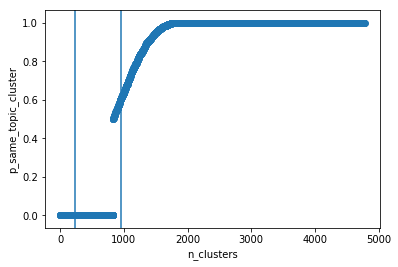

In [32]:
plt.scatter(np.arange(ac_result.shape[0]), -ac_result_dec[:, 2])
plt.axvline(n_articles//20)
plt.axvline(n_articles//5)
plt.xlabel('n_clusters')
plt.ylabel('p_same_topic_cluster')
plt.show()
plt.close()

In [33]:
n_clusters = np.where((-ac_result_dec[:,2]) > p_same_cluster_threshold)[0][0] + 1

In [34]:
n_clusters

833

In [35]:
subset.loc[:, 'topic_cluster_id'] = gen_clusters(ac_result, n_clusters)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [36]:
topic_cluster_id_counts = subset['topic_cluster_id'].value_counts()

In [37]:
(np.sum(topic_cluster_id_counts.values[topic_cluster_id_counts.values >= 20])
 /np.sum(topic_cluster_id_counts.values))

0.5541614387285655

In [38]:
topic_cluster_id_counts

8650    437
8715    395
8729    198
8642    185
8711    185
8709    109
8704    100
8694     91
8680     89
8665     88
8653     73
8702     66
7962     62
8705     52
8637     37
8296     36
8691     32
8589     25
8634     25
8394     25
7980     24
8655     24
8337     23
8508     23
8505     22
8532     21
8331     21
8660     21
8707     21
8220     20
       ... 
3487      1
3372      1
3380      1
3627      1
3048      1
989       1
1622      1
3679      1
569       1
2624      1
4683      1
4691      1
2692      1
4747      1
4771      1
4775      1
4779      1
3667      1
3631      1
1618      1
3659      1
2880      1
3651      1
2952      1
458       1
925       1
104       1
969       1
977       1
2099      1
Name: topic_cluster_id, Length: 833, dtype: int64

In [39]:
iterations = 0 
for idx, ct in zip(topic_cluster_id_counts.index, topic_cluster_id_counts.values):
    iterations += 1
    if iterations < 100:
        print('\n\n')
        print('%d articles in cluster %d' % (ct, idx))
        cluster_content = subset[
            subset['topic_cluster_id'] == idx
        ]
        articles=len(cluster_content)
        for num, row in cluster_content[:min(20, articles)].iterrows():
            print('HEADLINE: '+row['title'])
#             print('Publisher: '+row['feed_url'])
#             print('SUMMARY: '+row['generated_summary'])
#             print('\n')




437 articles in cluster 8650
HEADLINE: US to Announce Withdrawal From INF Nuclear Arms Treaty
HEADLINE: What Is the INF Treaty and Why Is the U.S. Withdrawing From Nuclear Arms Pact With Russia?
HEADLINE: Trump Ditching Our Nuclear Treaty with Russia Betrays Reagan’s Legacy—and Endangers The World | Opinion
HEADLINE: Nuclear 'Arms Race'? Russia Warns Main U.S. Treaty Limiting Weapons Will Be Next to Go After Trump Leaves Missile Pact
HEADLINE: Donald Trump Prepares 'Military Response Options' Against Russia as U.S. Leaves Nuclear Weapons Treaty
HEADLINE: Donald Trump Abandoning Nuclear Treaty With Russia Prompts Calls for Urgent Measures to Avoid Arms Race
HEADLINE: Russia Pulls Out of Nuclear Arms Treaty, Following U.S. Withdrawal
HEADLINE: US poised to withdraw from nuclear arms treaty with Russia
HEADLINE: US withdrawing from landmark nuclear arms treaty with Russia
HEADLINE: Russia expanded nuclear missile system despite treaty with US: official
HEADLINE: Putin: Russia will only

HEADLINE: Amnesty condemns ‘disgraceful’ US ‘Remain in Mexico’ policy



12 articles in cluster 8506
HEADLINE: Cory Booker Is Running for President
HEADLINE: Trump: Harris had ‘best opening’ of 2020 Dems
HEADLINE: Booker tells lawmakers he is running for president and seeks their support
HEADLINE: Warren teases ‘big announcement’ for 2020 plans
HEADLINE: With mom by his side, Booker signs paperwork declaring candidacy for president
HEADLINE: Gillibrand welcomes Booker into 2020 race: 'I'll be cheering you on' but 'not TOO hard'
HEADLINE: Kellyanne Conway: Cory Booker 'sounds like a Hallmark card'
HEADLINE: Hirono: 'I think Schultz should run as a Democrat'
HEADLINE: Warren enters year with most cash among likely 2020 contenders in Senate
HEADLINE: Conway: If Booker were Republican, they'd call him sexist for running against so many women
HEADLINE: Booker to Gillibrand: ‘We will always be family’
HEADLINE: Five takeaways from the latest fundraising reports in the lead-up to 2020



12 a

## Cluster same_cluster_probs graph - LOAD TEST

In [40]:
subset = recent_content_corpus.df[
    ((recent_content_corpus.df.topic_categorization_probability >= 0))
]
subset.loc[:, 'const'] = np.zeros(len(subset))
subset.loc[:, 'n'] = np.arange(len(subset))

In [41]:
sys.getsizeof(subset)/1e6

291.32805

In [42]:
n_articles = len(subset)
print(n_articles)

42937


In [43]:
%%time
X = -get_same_topic_cluster_probs(subset).tocsr()
C = csr_matrix(X < 0, dtype='bool')
p_same_cluster_threshold = 0.5

CPU times: user 12min 2s, sys: 3min 56s, total: 15min 58s
Wall time: 11min 50s


^ ~4 gb of memory used

In [44]:
%%time
ac_result = agglomeratively_cluster_dist_matrix(X, C, max_merge_dist=-p_same_cluster_threshold)

CPU times: user 2min 18s, sys: 6.75 s, total: 2min 25s
Wall time: 2min 33s


^ ~4 gb of memory used

In [45]:
ac_result.shape

(31074, 3)

In [46]:
# if disconnected graph with early stopping, extend ac_result with dummy data for gen_clusters compatibility
to_append = np.array([[1e6, 1e6, 0] for i in range(n_articles - 1 - ac_result.shape[0])]) # 
if to_append.size > 0:
    ac_result = np.vstack((ac_result, to_append))

In [47]:
ac_result_dec = ac_result[::-1] # easier to work with

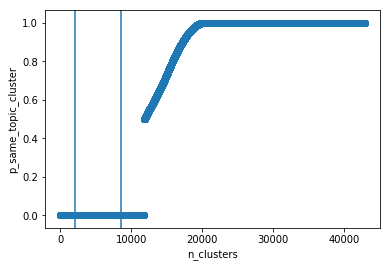

In [48]:
plt.scatter(np.arange(ac_result.shape[0]), -ac_result_dec[:, 2])
plt.axvline(n_articles//20)
plt.axvline(n_articles//5)
plt.xlabel('n_clusters')
plt.ylabel('p_same_topic_cluster')
plt.show()
plt.close()

In [49]:
n_clusters = np.where((-ac_result_dec[:,2]) > p_same_cluster_threshold)[0][0] + 1

In [50]:
n_clusters

11863

In [51]:
subset.loc[:, 'topic_cluster_id'] = gen_clusters(ac_result, n_clusters)

In [52]:
topic_cluster_id_counts = subset['topic_cluster_id'].value_counts()

In [53]:
(np.sum(topic_cluster_id_counts.values[topic_cluster_id_counts.values >= 20])
 /np.sum(topic_cluster_id_counts.values))

0.3166033956727298

In [54]:
topic_cluster_id_counts

73289    576
73805    393
74004    318
73936    253
73723    202
72867    202
73551    195
73938    194
73786    183
72700    168
73411    162
73843    141
73705    131
73319    130
73369    120
73041    119
73757    115
72491    111
73753    111
72719    108
71085    107
73766    106
73851    106
73611    100
73837     96
73020     94
73403     91
73836     91
73987     89
65563     88
        ... 
27290      1
4757       1
6804       1
42271      1
25895      1
2774       1
33543      1
15152      1
41763      1
37881      1
7411       1
33787      1
31748      1
37669      1
15372      1
8114       1
31780      1
13357      1
6993       1
17539      1
31812      1
25671      1
21277      1
15436      1
11342      1
27750      1
25703      1
13421      1
40056      1
14185      1
Name: topic_cluster_id, Length: 11863, dtype: int64

In [55]:
iterations = 0 
for idx, ct in zip(topic_cluster_id_counts.index, topic_cluster_id_counts.values):
    iterations += 1
    if iterations < 100:
        print('\n\n')
        print('%d articles in cluster %d' % (ct, idx))
        cluster_content = subset[
            subset['topic_cluster_id'] == idx
        ]
        articles=len(cluster_content)
        for num, row in cluster_content[:min(20, articles)].iterrows():
            print('HEADLINE: '+row['title'])
#             print('Publisher: '+row['feed_url'])
#             print('SUMMARY: '+row['generated_summary'])
#             print('\n')




576 articles in cluster 73289
HEADLINE: US to Announce Withdrawal From INF Nuclear Arms Treaty
HEADLINE: What Is the INF Treaty and Why Is the U.S. Withdrawing From Nuclear Arms Pact With Russia?
HEADLINE: Nuclear 'Arms Race'? Russia Warns Main U.S. Treaty Limiting Weapons Will Be Next to Go After Trump Leaves Missile Pact
HEADLINE: Donald Trump Prepares 'Military Response Options' Against Russia as U.S. Leaves Nuclear Weapons Treaty
HEADLINE: Donald Trump Abandoning Nuclear Treaty With Russia Prompts Calls for Urgent Measures to Avoid Arms Race
HEADLINE: Russia Pulls Out of Nuclear Arms Treaty, Following U.S. Withdrawal
HEADLINE: US poised to withdraw from nuclear arms treaty with Russia
HEADLINE: US withdrawing from landmark nuclear arms treaty with Russia
HEADLINE: Russia expanded nuclear missile system despite treaty with US: official
HEADLINE: Putin: Russia will only deploy new missiles if US does
HEADLINE: Russia to pull plug on nuclear arms pact after US does the same
HEADLIN

HEADLINE: Qatar soccer team wins Asian Cup despite accusations from UAE of fielding eligible players
HEADLINE: Qatar soccer team wins Asian Cup despite accusations from UAE of fielding ineligible players
HEADLINE: Qatar beat Japan 3-1 to win Asian Cup for first time
HEADLINE: He’s our Guardiola: Qatar coach hailed after stunning Asian win
HEADLINE: UAE protest at eligibility of Qataris dismissed on day of final
HEADLINE: Qatari goal machine Ali targets Europe move before 2022 World Cup
HEADLINE: Qatar beat Japan 3-1 to win Asian Cup for first time
HEADLINE: Ali on target as Qatar stun Japan to win first Asian Cup
HEADLINE: Soccer: Ali on target as Qatar stun Japan to win first Asian Cup
HEADLINE: Asian Cup final: Qatar leads Japan 2-0 on great goals (VIDEO)
HEADLINE: Ahead of 2022 World Cup, Qatar beats Japan to win Asian Cup
HEADLINE: UAE tries to thwart Qatar Asian Cup final debut with protest
HEADLINE: Asian Cup: Qatar upset Japan 3-1 to claim first title
HEADLINE: Qatar beat Japan 

HEADLINE: EPL news: Maurizio Sarri, Chelsea form, statistics, Premier League, team news, Scolari
HEADLINE: EPL results, goals, video, highlights, Chelsea vs Huddersfield, Spurs vs Newcastle, Everton vs Wolves
HEADLINE: Higuain eases pressure on Sarri as Chelsea cruise
HEADLINE: Chelsea will not tweak style despite poor run, says Sarri
HEADLINE: Maurizio Sarri Criticised 'Selfish' Eden Hazard in Changing Room Meeting After Bournemouth Loss
HEADLINE: Maurizio Sarri Explains Why He Won't Abandon Signature Style and Talks Down Pressure of Chelsea Job
HEADLINE: Didi Hamann Questions Chelsea Players' Loyalty to Maurizio Sarri After Dressing Room Revolts
HEADLINE: Chelsea 5-0 Huddersfield: Report, Ratings & Reaction as Gonzalo Higuain Opens Blues Account in Style
HEADLINE: Spurs go second, Chelsea thrash Terriers
HEADLINE: Spurs go second, Chelsea thrash Terriers
HEADLINE: Spurs go second, Chelsea thrash Terriers
HEADLINE: Chelsea manager Maurizio Sarri, fans losing patience at Stamford Bridg

HEADLINE: 15 years of Facebook: has it made the world, and Australia, a better place?
HEADLINE: Is Apple's Tim Cook the only person who can regulate Facebook?
HEADLINE: Is Apple's Tim Cook the only person who can regulate Facebook?
HEADLINE: The fallout from Facebook’s controversial research app
HEADLINE: Facebook paid to spy on minors. It’s another reason Congress must act.
HEADLINE: “Sheryl Isn’t Going Anywhere”: After Crushing Wall Street, Facebook Opens the Trump Playbook to Gloss Over Its Scandalmania
HEADLINE: “Sheryl Isn’t Going Anywhere”: After Crushing Wall Street, Facebook Opens the Trump Playbook to Gloss Over Its Scandalmania
HEADLINE: Facebook at 15: a titan with grown-up woes



68 articles in cluster 70397
HEADLINE: January was Australia’s hottest month on record
HEADLINE: January 2019 was Australia’s hottest month ever recorded
HEADLINE: January officially Australia's hottest month on record
HEADLINE: Australia had hottest month on record in January: weather bureau
HEAD

HEADLINE: 286 Texas Catholic Priests Accused of Sexual Abuse
HEADLINE: Catholic Church in Texas Names Nearly 300 Priests Accused of Sex Abuse
HEADLINE: US Catholic leaders name nearly 300 priests accused of abuse
HEADLINE: Catholic leaders in Texas name around 300 priests accused of abuse
HEADLINE: Catholic leaders in Texas name around 300 priests accused of abuse
HEADLINE: Catholic leaders in Texas accuse hundreds of priests of abuse
HEADLINE: Here are names of Houston-area priests ‘credibly accused’ of child sexual abuse
HEADLINE: Catholic Leaders In Texas Identify 286 Clergy Members Accused Of Sexual Abuse
HEADLINE: Catholic leaders in Texas name 286 accused of abusing minors
HEADLINE: Catholic leaders in Texas name 286 accused of abusing minors
HEADLINE: Catholic leaders in Texas name 286 accused of abusing minors
HEADLINE: US bishops release names of 300 Texas clergy accused of abuse
HEADLINE: Catholic leaders in Texas name 286 accused of abusing minors
HEADLINE: Louisiana diocese

# Make subtopic cluster classifier

## Sample some article pairs

In [ ]:
big_clusters = topic_cluster_id_counts[topic_cluster_id_counts.values >= 25].index

In [ ]:
subset2 = subset[
    subset['topic_cluster_id'].apply(
        lambda x: x in big_clusters
    )
]

In [ ]:
def sample_article_pairs_same_topic_cluster(df, n, extra_fields=None):
    fields = ['_id', 'topic_cluster_id']
    if extra_fields:
        fields += extra_fields
    
    first_articles = df[fields].sample(n, replace=True).reset_index()
    first_articles.columns = [colname + '_0' for colname in first_articles.columns]
    
    second_articles = [df.loc[df.topic_cluster_id == tcid,
                              fields].sample(1)
                       for tcid in first_articles['topic_cluster_id_0'].values]
    second_articles = reduce(lambda x, y: x.append(y), second_articles).reset_index()
    second_articles.columns = [colname + '_1' for colname in second_articles.columns]
    
    article_pairs = pd.concat([first_articles, second_articles], axis=1)
    
    return article_pairs
    

In [ ]:
subtopic_cluster_training_article_pairs = sample_article_pairs_same_topic_cluster(
    subset2, 1000, extra_fields=['title']
)

In [ ]:
subtopic_cluster_training_article_pairs

## Calculate metrics for sampled pairs

In [56]:
def selected_subtopic_article_pairs_metrics(df):
    title_dists = np.zeros(len(df))
    text_dists = np.zeros(len(df))
    text_nouns_dists = np.zeros(len(df))
    text_adjs_dists = np.zeros(len(df))
    title_dense_dists = np.zeros(len(df))
    text_dense_dists = np.zeros(len(df))

    for idx, row in df.iterrows():
        article_1_idx = row['index_0']
        article_2_idx = row['index_1']

        title_dist, text_dist, text_nouns_dist, text_adjs_dist = (
            article_pair_metrics(article_1_idx, article_2_idx)
        )
        
        title_dense_dist = np.round(cosine(
            titles_dense_matrix[article_1_idx],
            titles_dense_matrix[article_2_idx]
        ), 4)
        
        text_dense_dist = np.round(cosine(
            texts_dense_matrix[article_1_idx],
            texts_dense_matrix[article_2_idx]
        ), 4)

        title_dists[idx] = title_dist
        text_dists[idx] = text_dist
        text_nouns_dists[idx] = text_nouns_dist
        text_adjs_dists[idx] = text_adjs_dist
        title_dense_dists[idx] = title_dense_dist
        text_dense_dists[idx] = text_dense_dist

    df['title_dist'] = title_dists
    df['text_dist'] = text_dists
    df['text_nouns_dist'] = text_nouns_dists
    df['text_adjs_dist'] = text_adjs_dists
    df['title_dense_dist'] = title_dense_dists
    df['text_dense_dist'] = text_dense_dists

    return df

In [ ]:
%%time
subtopic_cluster_training_article_pairs = selected_subtopic_article_pairs_metrics(
    subtopic_cluster_training_article_pairs
)

In [ ]:
subtopic_cluster_training_article_pairs.head()

In [ ]:
# subtopic_cluster_training_article_pairs.to_csv('subtopic_cluster_training_article_pairs.csv')

## Label the sampled pairs

[ done manually ]

## Ingest the labeled pairs

In [154]:
labeled_sc_pairs = pd.read_csv('../data/labeled_subtopic_cluster_training_article_pairs_v2.csv')

In [155]:
labeled_sc_pairs.reset_index()

index  Unnamed: 0  index_0                     _id_0  topic_cluster_id_0  \
0        0           0     6165  5c54e8ea9cbe064b2dc0aeb2               73237   
1        1           1    20960  5c5411f19cbe067c8d1da5c5               73089   
2        2           2    26033  5c55e34a9cbe064241b37885               70434   
3        3           3    16113  5c5435b89cbe0614e67ec01e               71741   
4        4           4    20312  5c5411cf9cbe067bd29eaf17               72930   
5        5           5    40669  5c53c6129cbe0617a4e1fdf3               72916   
6        6           6     6271  5c540eca9cbe0660ce54594a               71701   
7        7           7    14591  5c5402fb9cbe06027b6ebe7f               72865   
8        8           8    27477  5c542b3b9cbe0648afddeb7c               71905   
9        9           9    38267  5c540eee9cbe0662ae49ca1c               73113   
10      10          10    17364  5c53e0189cbe0666af0d76c8               72915   
11      11          11    37926  5c54ea309cbe065616f76e91               72156   
12      12          12    38525  5c53b7ae9cbe061878947599               72685   
13      13          13    29971  5c53ee999cbe065e8277324a               72450   
14      14          14    19249  5c5451289cbe067bae8d6258               73090   
15      15          15    32581  5c549e7f9cbe067234e32935               72707   
16      16          16    11601  5c555a9e9cbe0668d6e0170c               72539   
17      17          17    26635  5c54be229cbe066f633c99eb               72262   
18      18          18     9524  5c53672a9cbe06112d09cfd1               69044   
19      19          19    21707  5c54fa109cbe065a0ff03ce0               73036   
20      20          21    14405  5c5496939cbe0630bc869fbb               73089   
21      21          22    26413  5c544cfa9cbe065aefbed608               72339   
22      22          23    11664  5c5448b69cbe06363175f2ba               71741   
23      23          24    11925  5c5383b89cbe0676e1cd74d6               72788   
24      24          25     6894  5c54a2c29cbe0613cc187fc9               71778   
25      25          26     6304  5c547f699cbe067276595fbf               69358   
26      26          27    37588  5c5420159cbe066f4cf488f6               71605   
27      27          28    41663  5c546a309cbe064635a821f8               72339   
28      28          29    37226  5c53b35b9cbe0673f48d46b5               72678   
29      29          30    14203  5c5450309cbe06738b3d9a6b               72923   
..     ...         ...      ...                       ...                 ...   
935    935         947    26674  5c538fe99cbe065917cf6526               72469   
936    936         948    41404  5c53ecb39cbe064c88c820e6               72569   
937    937         949    19494  5c53c4269cbe06065d7680c3               71500   
938    938         950    38912  5c53e2439cbe067a5363a2e4               72930   
939    939         951    41250  5c55d3929cbe063fe3d49331               72156   
940    940         952    28351  5c544ff29cbe0670f97e1d4e               67172   
941    941         953     3561  5c54ef969cbe060181a2fe0e               72951   
942    942         954    13615  5c54f20b9cbe06158f2e08e0               70757   
943    943         955    42791  5c5458309cbe0633d86c84b9               68633   
944    944         956    41898  5c54158e9cbe0618105a1bf4               72609   
945    945         957    38937  5c53f7539cbe0626c5788602               72930   
946    946         958    14121  5c536f539cbe0650256009c3               72923   
947    947         959    28568  5c548f3c9cbe06732cc094e6               73206   
948    948         960    42929  5c55ceef9cbe06200bb738a5               73241   
949    949         961    40009  5c548e5e9cbe066cec1324a7               69612   
950    950         962    38438  5c53f4eb9cbe0610d9e1a95f               70618   
951    951         963    18213  5c55e82a9cbe06692ab5416b               72951   
952    952         964    27768  5c5

In [156]:
labeled_sc_pairs = selected_subtopic_article_pairs_metrics(labeled_sc_pairs)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/spatial/distance.py:698: RuntimeWarning: invalid value encountered in float_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


In [157]:
labeled_sc_pairs = labeled_sc_pairs[
    labeled_sc_pairs.same_subtopic_cluster.apply(lambda x: x in [0, 1])
]

In [158]:
labeled_sc_pairs.shape

(965, 16)

## Fit classifier

In [204]:
features = ['title_dist', 'text_dist', 'text_nouns_dist', 'text_adjs_dist', 
            'title_dense_dist', 'text_dense_dist']

In [205]:
for feature in features:
    labeled_sc_pairs[feature] = (
        labeled_sc_pairs[feature].apply(lambda x: 1 if np.isnan(x) else x)
    )


Mean precision: 0.8333543467827095


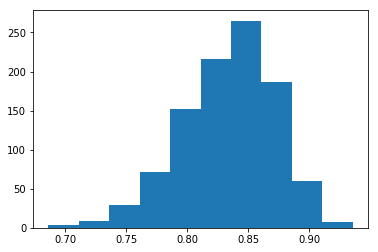

Mean recall: 0.6399966045534402


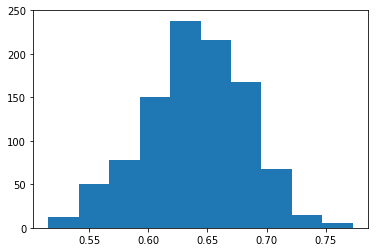

In [206]:
sgds = []
precisions = []
recalls = []
f1s = []
for i in tqdm_notebook(np.arange(1000)):
    X = labeled_sc_pairs[features]
    y = labeled_sc_pairs['same_subtopic_cluster']

    X_train, X_test, y_train, y_test = (
        train_test_split(X, y, test_size=0.5)
    )

    sgd = SGDClassifier(
        loss='log',
        max_iter=100,
        n_jobs=2,
        learning_rate='optimal',
        penalty='l2',
        alpha=0.001,
        l1_ratio=0.15
    )
    sgd.fit(X_train, y_train)

    pred = sgd.predict(X_test)
    
    sgds += [sgd]
    precision = metrics.precision_score(y_test, pred)
    precisions += [precision]
    recall = metrics.recall_score(y_test, pred)
    recalls += [metrics.recall_score(y_test, pred)]
    f1 = 2 * precision * recall / (precision + recall)
    f1s += [f1]
    
print('Mean precision: %s' % str(np.mean(precisions)))
plt.hist(precisions)
plt.show()
print('Mean recall: %s' % str(np.mean(recalls)))
plt.hist(recalls)
plt.show()

In [207]:
f1_max_arg = np.argmax(f1s)

In [208]:
precisions[f1_max_arg]

0.8109756097560976

In [209]:
recalls[f1_max_arg]

0.76

In [231]:
scc = sgds[f1_max_arg]
with open('../models/subtopic_cluster_classifier.pkl', 'wb') as output:
    pickle.dump(scc, output, pickle.HIGHEST_PROTOCOL)

In [ ]:
# with open('../models/subtopic_cluster_classifier.pkl', 'rb') as input:
#     scc = pickle.load(input)

In [211]:
labeled_sc_pairs['same_subtopic_cluster_predicted'] = (
    scc.predict(X)
)
labeled_sc_pairs['same_subtopic_cluster_probability'] = (
    scc.predict_proba(X)[:, 1]
)

In [212]:
for idx, row in labeled_sc_pairs[
    ((labeled_sc_pairs.same_subtopic_cluster == 0)
     & (labeled_sc_pairs.same_subtopic_cluster_predicted == 1))
].iterrows():
    print('\n')
    print(row['title_0'])
    print(row['title_1'])
    print(row['text_dist'])
    print(row['title_dist'])



Trump to meet China's Xi to try to seal trade deal, progress reported
'Tremendous' progress in US-China trade talks: Donald Trump
0.4046
0.7232


Nintendo's Switch magic may be wearing off
New Nintendo Switch “Mini” Console Rumored to Release in 2019
0.4025
0.6687


Rickie Fowler carves out one-shot lead over Justin Thomas at Phoenix Open
Phoenix Open: Rickie Fowler, Justin Thomas in 3-way tie for lead
0.6115
0.2678


Facebook bans accounts tied to Indonesian fake news group
Facebook removes 783 fake pages, accounts tied to Iran
0.6563
0.5432


Super Bowl LIII: New England Patriots and Tom Brady look to make history against Los Angeles Rams
NFL Super Bowl: New England Patriots vs Los Angeles Rams, start time, where, halftime, odds
0.3727
0.4629


Mother and son ‘shocked’ at finding baby in freezing park
Newborn baby girl found abandoned in London park amid freezing temperatures
0.5233
0.6522


Putin: Russia will only deploy new missiles if US does
The Latest: US formally suspends INF

In [213]:
for idx, row in labeled_sc_pairs[
    ((labeled_sc_pairs.same_subtopic_cluster == 1)
     & (labeled_sc_pairs.same_subtopic_cluster_predicted == 0))
].iterrows():
    print('\n')
    print(row['title_0'])
    print(row['title_1'])
    print(row['text_dist'])
    print(row['title_dist'])



U.S. border officials announce largest-ever fentanyl seizure, enough for 100 million lethal doses
Concealed By Cucumbers, Massive Fentanyl Stash Found In Produce Truck In Arizona
0.3686
0.8887


Australia win toss, bat in 2nd Sri Lanka Test
Australia v Sri Lanka: second Test, day two – live!
0.8114
0.498


Twelve Russian athletes banned for doping by Court of Arbitration for Sport
CAS hits 12 Russians with doping bans including Olympic champ Ukhov
0.4253
0.877


Exxon Mobil profits top estimates on better oil output
Exxon Mobil, Chevron Q4 Earnings Beat View, But Revenues Miss
0.7254
0.7115


Removing Coordinated Inauthentic Behavior From Iran
Facebook and Twitter Take Down a Wave of Political Manipulation
0.4739
1.0


Caught on cam: Man tosses ice cubes on floor, fakes fall, police say
Watch This Guy Allegedly Fake a Fall for Insurance Money and Fail Miserably
0.7412
0.9238


Union Budget 2019-20 LIVE: FM Goyal says no tax on income up to Rs 5 lakh; no notional rent on 2nd home
Budg

# Supervised topic clustering

## Generate same_subtopic_cluster_probs graph

In [214]:
def get_same_subtopic_cluster_probs(subset, pairs_dists_max_memory_use_mb=500):
    n_articles = len(subset)
    subset_indices = subset.index.values
    
    same_subtopic_cluster_probs = lil_matrix((n_articles, n_articles))
    num_dist_matrices = 6
    per_dist_matrix_max_memory = pairs_dists_max_memory_use_mb / num_dist_matrices / 2
    cols_batch = int(min(n_articles, per_dist_matrix_max_memory/8e-6))
    rows_batch = int(min(n_articles, per_dist_matrix_max_memory/(cols_batch * 8e-6)))

    # slice first articles
    for start_row in np.arange(0, n_articles, rows_batch):
        end_row = min(start_row+rows_batch, n_articles)

        # get first articles' vectors
        first_article_indices = subset_indices[start_row:end_row]
        first_titles_tfidf_matrix = recent_content_corpus.titles_tfidf_matrix[first_article_indices]
        first_texts_tfidf_matrix = recent_content_corpus.texts_tfidf_matrix[first_article_indices]
        first_nouns_tfidf_matrix = texts_nouns_tfidf_matrix[first_article_indices]
        first_adjs_tfidf_matrix = texts_adjs_tfidf_matrix[first_article_indices]
        first_titles_dense_matrix = titles_dense_matrix[first_article_indices]
        first_texts_dense_matrix = texts_dense_matrix[first_article_indices] 

        # slice second articles
        for start_col in np.arange(start_row, n_articles, cols_batch):
            end_col = min(start_col+cols_batch, n_articles)

            # get second articles' vectors
            second_article_indices = subset_indices[start_col:end_col]    
            second_titles_tfidf_matrix = recent_content_corpus.titles_tfidf_matrix[second_article_indices]
            second_texts_tfidf_matrix = recent_content_corpus.texts_tfidf_matrix[second_article_indices]
            second_nouns_tfidf_matrix = texts_nouns_tfidf_matrix[second_article_indices]
            second_adjs_tfidf_matrix = texts_adjs_tfidf_matrix[second_article_indices]
            second_titles_dense_matrix = titles_dense_matrix[second_article_indices]
            second_texts_dense_matrix = texts_dense_matrix[second_article_indices]

            # create article pairs distance matrices
            titles_dists = 1-cosine_similarity(first_titles_tfidf_matrix, second_titles_tfidf_matrix)
            texts_dists = 1-cosine_similarity(first_texts_tfidf_matrix, second_texts_tfidf_matrix)
            nouns_dists = 1-cosine_similarity(first_nouns_tfidf_matrix, second_nouns_tfidf_matrix)
            adjs_dists = 1-cosine_similarity(first_adjs_tfidf_matrix, second_adjs_tfidf_matrix)
            titles_dense_dists = 1-cosine_similarity(first_titles_dense_matrix, second_titles_dense_matrix)
            texts_dense_dists = 1-cosine_similarity(first_texts_dense_matrix, second_texts_dense_matrix)
            
            # conserve memory
            del second_article_indices, second_titles_tfidf_matrix, second_texts_tfidf_matrix,\
                second_nouns_tfidf_matrix, second_adjs_tfidf_matrix, first_titles_dense_matrix,\
                first_texts_dense_matrix, second_titles_dense_matrix, second_texts_dense_matrix
            
            # combine article pairs distances
            pairs_metrics = pd.merge(
                subset[['const', 'n']][start_row:end_row], 
                subset[['const', 'n']][start_col:end_col], 
                on='const'
            )
            pairs_metrics['title_dist'] = titles_dists.reshape(-1)
            pairs_metrics['text_dist'] = texts_dists.reshape(-1)
            pairs_metrics['text_nouns_dist'] = nouns_dists.reshape(-1)
            pairs_metrics['text_adjs_dist'] = adjs_dists.reshape(-1)
            pairs_metrics['title_dense_dist'] = titles_dense_dists.reshape(-1)
            pairs_metrics['text_dense_dist'] = texts_dense_dists.reshape(-1)
            
            # conserve memory
            del titles_dists, texts_dists, nouns_dists, adjs_dists, titles_dense_dists,\
                texts_dense_dists

            # estimate p(same_cluster)
            pairs_metrics['same_subtopic_cluster_probability'] = (
                scc.predict_proba(pairs_metrics[features])[:, 1]
            )
            
            pairs_metrics = pairs_metrics[
                pairs_metrics['same_subtopic_cluster_probability'] > 0
            ]
            
            for x, y, p in zip(pairs_metrics['n_x'],
                               pairs_metrics['n_y'],
                               pairs_metrics['same_subtopic_cluster_probability']):
                same_subtopic_cluster_probs[x, y] = same_subtopic_cluster_probs[y, x] = p
    
    return same_subtopic_cluster_probs

## Cluster same_subtopic_cluster_probs graph

In [215]:
subset2 = subset[
    subset.topic_cluster_id == topic_cluster_id_counts.index[0]
]

subset2.loc[:, 'const'] = np.zeros(len(subset2))
subset2.loc[:, 'n'] = np.arange(len(subset2))
subset2

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


_id           crawled_timestamp  \
102    5c5437ff9cbe062932f9adbe  2019-02-01 12:13:51.154991   
204    5c545aa49cbe0646666dc164  2019-02-01 14:41:39.873029   
228    5c547d889cbe0663871c7b9a  2019-02-01 17:10:32.727368   
251    5c5499449cbe06484df27b8e  2019-02-01 19:08:52.515342   
266    5c54c3429cbe061f4e378ea7  2019-02-01 22:08:01.995557   
304    5c55d5829cbe065234bcc775  2019-02-02 17:38:09.305221   
436    5c5431679cbe066fa087cc2b  2019-02-01 11:45:43.052458   
446    5c545ab09cbe0646dd5d1e7b  2019-02-01 14:41:52.889698   
483    5c54994c9cbe0648bc07bf69  2019-02-01 19:09:00.341354   
600    5c5579cd9cbe066bde3b8b80  2019-02-02 11:06:53.685023   
604    5c55ab309cbe067b7657939a  2019-02-02 14:37:36.950100   
687    5c53e2689cbe067c1e06dae2  2019-02-01 06:08:39.276690   
696    5c5453909cbe060f6da015c0  2019-02-01 14:11:27.466995   
823    5c535d199cbe06404a8eff27  2019-01-31 20:39:52.648186   
872    5c539c319cbe0642e42ef447  2019-02-01 01:09:04.076108   
879    5c54bc9a9cbe0668293bb2bd  2019-02-01 21:39:37.302380   
932    5c5395a49cbe060b6f595080  2019-02-01 00:41:07.518416   
944    5c5461ce9cbe0603f6d495db  2019-02-01 15:12:13.774331   
966    5c54d1489cbe06158922f6ef  2019-02-01 23:07:52.249581   
1221   5c546fa69cbe06765a30c5f8  2019-02-01 16:11:17.069514   
1232   5c54cac69cbe065cf12a896c  2019-02-01 22:40:05.221732   
1245   5c55b9a19cbe0672ac976665  2019-02-02 15:39:12.394489   
1620   5c547e459cbe066a20724135  2019-02-01 17:13:41.611435   
1713   5c541ba09cbe064b18bf091c  2019-02-01 10:12:48.659085   
1734   5c5445d19cbe062252c2abbb  2019-02-01 13:12:49.976736   
1742   5c5454179cbe0614ac51d8c4  2019-02-01 14:13:43.686108   
1801   5c5566169cbe064789cb1524  2019-02-02 09:42:46.106275   
2053   5c54547c9cbe0615ba724e11  2019-02-01 14:15:24.173980   
2054   5c545b839cbe064e29daac8c  2019-02-01 14:45:22.961677   
2082   5c55a6009cbe064a69a44a6b  2019-02-02 14:15:28.352676   
...                         ...                         ...   
39163  5c54559b9cbe061fa71d306f  2019-02-01 14:20:11.083816   
39187  5c55c3289cbe06392f3186f3  2019-02-02 16:19:52.881411   
39873  5c54933e9cbe06169b05e654  2019-02-01 18:43:10.333626   
39888  5c5526d99cbe06459ba01faf  2019-02-02 05:12:57.559769   
39925  5c55894f9cbe0664dfda4843  2019-02-02 12:13:03.280579   
40132  5c5594c59cbe0644a426aedf  2019-02-02 13:01:56.869706   
40193  5c542d709cbe0651fdcbde3f  2019-02-01 11:28:48.480030   
40197  5c5506239cbe063ca94f01cb  2019-02-02 02:53:22.371685   
40203  5c558bc09cbe067930695965  2019-02-02 12:23:27.488940   
40467  5c5428499cbe06308bb1e692  2019-02-01 11:06:49.893586   
40916  5c5432af9cbe067ad27e83f4  2019-02-01 11:51:10.613948   
41115  5c5588189cbe0660dee25535  2019-02-02 12:07:51.520199   
41325  5c5570219cbe061892a72f39  2019-02-02 10:25:37.133206   
41326  5c5570229cbe061892a72f3a  2019-02-02 10:25:38.353377   
41418  5c55306d9cbe061411425884  2019-02-02 05:53:48.706427   
41753  5c545d229cbe065c0e675c8d  2019-02-01 14:52:18.255871   
41956  5c5447209cbe062a236e6316  2019-02-01 13:18:24.491262   
42071  5c55d28a9cbe063611d26640  2019-02-02 17:25:29.679260   
42078  5c5419659cbe063982ca05fa  2019-02-01 10:03:17.720837   
42083  5c54ad0e9cbe06683a5f7929  2019-02-01 20:33:18.024189   
42138  5c557f039cbe061408b6eb80  2019-02-02 11:29:07.270542   
42187  5c558bb69cbe06787b2d840e  2019-02-02 12:23:17.443814   
42220  5c55705e9cbe061bf2841ad2  2019-02-02 10:26:38.145017   
42445  5c5569619cbe066371137777  2019-02-02 09:56:49.143757   
42492  5c5433069cbe067e4aff252e  2019-02-01 11:52:38.144991   
42511  5c553d2b9cbe0678c1bb39ad  2019-02-02 06:48:09.997620   
42787  5c54a2d99cbe06148b46a87e  2019-02-01 19:49:45.369017   
42788  5c559fe79cbe061c97409ac9  2019-02-02 13:49:27.165350   
42824  5c55a9539cbe066a1f4d9184  2019-02-02 14:29:38.174785   
42925  5c5591859cbe062709f07375  2019-02-02 12:48:04.573159   

                                                feed_url  \
102            https://www.newsmax.com/rss/Newsfront/16/   
2

In [216]:
sys.getsizeof(subset2)/1e6

3.687665

In [217]:
n_articles = len(subset2)
print(n_articles)

576


In [218]:
%%time
X = -get_same_subtopic_cluster_probs(subset2).tocsr()
C = csr_matrix(X < 0, dtype='bool')
p_same_cluster_threshold = 0.5

CPU times: user 3.23 s, sys: 146 ms, total: 3.38 s
Wall time: 2.9 s


In [219]:
%%time
ac_result = agglomeratively_cluster_dist_matrix(X, C, max_merge_dist=-p_same_cluster_threshold)

CPU times: user 941 ms, sys: 30.4 ms, total: 972 ms
Wall time: 1e+03 ms


In [220]:
ac_result.shape

(497, 3)

In [221]:
# if disconnected graph with early stopping, extend ac_result with dummy data for gen_clusters compatibility
to_append = np.array([[1e6, 1e6, 0] for i in range(n_articles - 1 - ac_result.shape[0])]) # 
if to_append.size > 0:
    ac_result = np.vstack((ac_result, to_append))

In [222]:
ac_result_dec = ac_result[::-1] # easier to work with

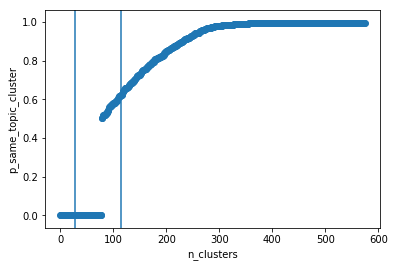

In [223]:
plt.scatter(np.arange(ac_result.shape[0]), -ac_result_dec[:, 2])
plt.axvline(n_articles//20)
plt.axvline(n_articles//5)
plt.xlabel('n_clusters')
plt.ylabel('p_same_topic_cluster')
plt.show()
plt.close()

In [224]:
n_clusters = np.where((-ac_result_dec[:,2]) > p_same_cluster_threshold)[0][0] + 1

In [225]:
n_clusters

79

In [226]:
subset2.loc[:, 'subtopic_cluster_id'] = gen_clusters(ac_result, n_clusters)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [227]:
subtopic_cluster_id_counts = subset2['subtopic_cluster_id'].value_counts()

In [228]:
(np.sum(subtopic_cluster_id_counts.values[subtopic_cluster_id_counts.values >= 10])
 /np.sum(subtopic_cluster_id_counts.values))

0.7083333333333334

In [229]:
subtopic_cluster_id_counts

1070    213
1045     63
1059     61
1065     33
1022     14
1071     13
959      11
1067      9
1008      7
1051      6
1068      5
827       5
825       5
1047      5
1060      5
735       4
1057      4
655       4
760       4
1066      4
816       4
980       4
1072      4
1052      4
1064      3
650       3
1062      3
790       3
1058      3
1044      3
       ... 
19        1
187       1
160       1
368       1
200       1
211       1
530       1
506       1
492       1
491       1
489       1
438       1
403       1
391       1
390       1
380       1
372       1
371       1
370       1
367       1
364       1
345       1
344       1
343       1
342       1
333       1
311       1
298       1
248       1
4         1
Name: subtopic_cluster_id, Length: 79, dtype: int64

In [230]:
iterations = 0 
for idx, ct in zip(subtopic_cluster_id_counts.index, subtopic_cluster_id_counts.values):
    iterations += 1
    if iterations < 100:
        print('\n\n')
        print('%d articles in cluster %d' % (ct, idx))
        cluster_content = subset2[
            subset2['subtopic_cluster_id'] == idx
        ]
        articles=len(cluster_content)
        for num, row in cluster_content[:min(20, articles)].iterrows():
            print('HEADLINE: '+row['title'])
#             print('Publisher: '+row['feed_url'])
#             print('SUMMARY: '+row['generated_summary'])
#             print('\n')




213 articles in cluster 1070
HEADLINE: US to Announce Withdrawal From INF Nuclear Arms Treaty
HEADLINE: What Is the INF Treaty and Why Is the U.S. Withdrawing From Nuclear Arms Pact With Russia?
HEADLINE: Russia Pulls Out of Nuclear Arms Treaty, Following U.S. Withdrawal
HEADLINE: US poised to withdraw from nuclear arms treaty with Russia
HEADLINE: US withdrawing from landmark nuclear arms treaty with Russia
HEADLINE: US poised to announce withdrawal from nuclear arms treaty
HEADLINE: The Latest: NATO says Russia in breach of arms treaty
HEADLINE: US Expected to Announce INF Treaty Withdrawal as Soon as Friday
HEADLINE: US expected to announce withdrawal from cold war arms treaty as soon as Friday
HEADLINE: Russia Pulls Out of Nuclear Treaty in ‘Symmetrical’ Response to U.S. Move
HEADLINE: U.S. Announces It Will Withdraw From Nuclear Arms Control Treaty With Russia
HEADLINE: U.S. suspends compliance with INF treaty, may withdraw in six months
HEADLINE: Trump makes it official: U.S. 